#Identifying Fraund from Enron Email

<em><small>Uirá Caiado. June 21, 2015</small></em>

----------

###Abstract

I explore the public Enron financial and email dataset to identify Enron Employees who may have committed fraud. My goal is to build a machine learning algorithm to solve this chalange.

###Introduction

According to <a href="https://en.wikipedia.org/wiki/Enron">Wikipedia</a>, Enron was an energy, commodities, and services company that had employed approximately 20,000 staff. It was one of the largest companies in the United States, with claimed revenues of nearly $111 billion during 2000.

Also, it was one of the largest business scandals in American history, falling into bankruptcy in 2001 after was revealed widespread corporate fraud. As pointed out in the Udacity <a href="https://docs.google.com/document/d/10GYepNkDj-Kc_Sf6to3WX_q_SdymPOBJf3H-pq7a62g/pub">project description</a>, in the resulting Federal investigation, there was a significant amount of typically confidential information entered into the public record, including emails and financial data for top executives.

Given that there is a list of people who were somewhat involved in the scandal, here called person of interest (POI), I will try to develop a machine learning algorithm to identify those people with an acceptable accuracy.

###Understanding the Dataset

#####Summarizing the dataset

The data set is relatively small, and the number of identified POIs is even smaller. There are 146 different data points, or people, in this collection, but just 18 were classified as POIs. Each data point has 21 features, although more than half of these features didn't display any information for 40% or more of all dataset, as shown below.

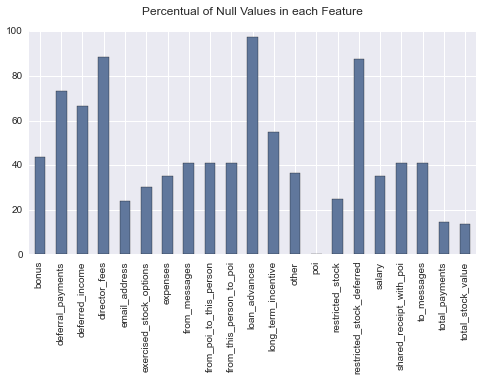

In [4]:
stats.NanAtFetaures()

Related to the features, I can categorize them into four groups:
- *Metadata*: 2 in total. If it is POI and email address. POI is what I want to predicted
- *Payments*: 10 in total. One is the summation and others are Salary, Bonus...
- *Stock Value*: 4 in total. One is also summation. for instance, Restricted stock options, Excercise stock options...
- *Emails*: 5 in total. Examples are "from POI to this person", "from messages"...

According to the documentary [The smartest guys in the room](https://www.youtube.com/watch?v=pRWXW87YrlM), the executives involved in the scandal used to exercise their option positions early. Later I will check if it can be a useful to identify POIs. Also, I don´t know if I will use the summations in Payments and Stock Value features. Maybe to look for outliers or to build new features. Excluding the both features, the POI features (that is the target) and the email address, it leaves me with 18 features to use.

Despite all the missing data, it still would be complex to analyze all possible correlations between these features. Here is where machine learning (ML) comes to play. Quonting this [book](http://www.amazon.com/Building-Machine-Learning-Systems-Python/dp/1782161406), ML teaches machines how to carry out tasks by themselves, providing them with a couple of examples.

#####Outlier Investigation

The point here is those examples mentioned. They should be VALID examples if I want to build a good estimator or classifier. Then, first of all, I need to look for outliers. Let's check it by looking some of the features.

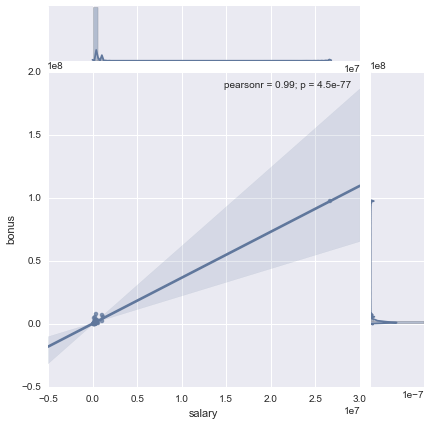

In [5]:
stats.scatter("salary", "bonus")

Here can be easily visualized that there is some data far away from the most of the data points. First, I am going to check who is in the top 10% of the "salary" feature.


In [5]:
stats.getDecile('salary')

,salary,poi
TOTAL,26704229,False


Hm... a summation. I will exclude this data point and run the scatter plot again 

In [20]:
df = stats.getData()
df.drop("TOTAL", inplace= True)
stats.setData(df)

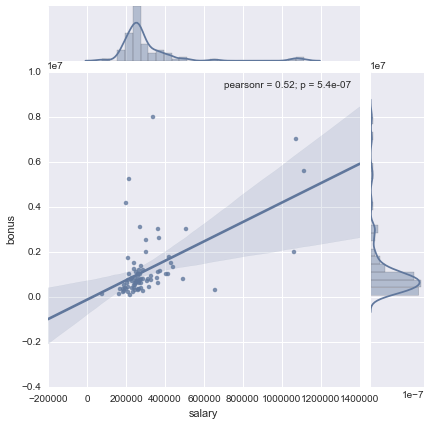

In [7]:
stats.scatter("salary", "bonus")

Much better. Looking at the last decile of each feature, I can see that neither salary or bonus seems hold real outliers. Curiously, the biggest bonus wasn't to a POI.

In [8]:
stats.getDecile('salary')

,salary,poi
SKILLING JEFFREY K,1111258,True


In [9]:
stats.getDecile('bonus')

,bonus,poi
LAVORATO JOHN J,8000000,False


Well... Let's look if there is another outlier. First, I will use the summations to check other features. Any difference between the values I will show in a line called "Delta".

In [10]:
df1, df2 = stats.checkSummation()
#checking Stocks feature
df1

,BELFER ROBERT
poi,0
restricted_stock,0
restricted_stock_deferred,44093
exercised_stock_options,3285
total_stock_value,-44093
Delta,91471


In [11]:
#checking Payments features
df2

,BELFER ROBERT,BHATNAGAR SANJAY
poi,0,0
bonus,0,0
deferral_payments,-102500,0
deferred_income,0,0
director_fees,3285,137864
expenses,0,0
loan_advances,0,0
long_term_incentive,0,0
other,0,137864
salary,0,0


Looking at the enron61702 pdf file, I can see that the differences above are due to some missing information. As it can bias the algorithms and both are non-POIs, I am going to exclude them.

In [19]:
df = stats.getData()
df.drop(["BELFER ROBERT","BHATNAGAR SANJAY"], inplace= True)
stats.setData(df)

Ok, now I am going show a description of all numeric data to see if there is any evidence of another outlier.

In [13]:
stats.describe()

,count,mean,std,min,25%,50%,75%,max
bonus,81.00,"1,201,773","1,441,679","70,000","425,000","750,000","1,200,000","8,000,000"
deferral_payments,37.00,"867,119","1,297,344","7,961","85,430","227,449","875,307","6,426,990"
deferred_income,48.00,"-581,050","942,076","-3,504,386","-611,209","-151,927","-37,926",-833
director_fees,14.00,"92,573","34,475","17,500","99,400","106,164","111,694","125,034"
exercised_stock_options,99.00,"2,993,007","5,547,033","9,803","549,008","1,297,049","2,416,963","34,348,384"
expenses,94.00,"54,192","46,108",148,"22,479","46,548","78,408","228,763"
from_messages,85.00,616,"1,851",12,22,41,146,"14,368"
from_poi_to_this_person,85.00,66,87,0,10,35,74,528
from_this_person_to_poi,85.00,42,101,0,1,8,25,609
loan_advances,3.00,"27,975,000","46,382,560","400,000","1,200,000","2,000,000","41,762,500","81,525,000"


Although there are pretty big numbers in the financial information, they are all related to executives from Eron. I guess that I am done here.

###Feature Selection and Engineering

- What features did you end up using in your POI identifier, and what selection process did you use to pick them?  

- Did you have to do any scaling? Why or why not?

- If you used an algorithm like a decision tree, please also give the feature importances of the features that you use.  

- [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]

#####Creating and Scaling Features

There are two points that caught my attention in the documentary "The Smartest Guys in The Room". First, some of the top executives used to spend a lot of the firm's money in strip clubs. Second, there were some employees who exercised much of their stock options earlier, knowing about the company's financial conditions. Based on these facts, I will include two more features to be tested:
- Expenses over maximum expense: I can't compare to another Payment features from the data points because the amount of money they had made with salary or bonus might diminish the importance of this features. Then, I will divide by the maximum number of the same feature
- Exercised Stock Option vs. Total of Payment: If a high stake of your money is in a company that you know that is going to crash, what would you do? Sell, sell as much as you can. I will divide the total of stock options that were exercised by the total of money each one has made (I will not consider the remain stock options). I want to know if the amount of options of each POIs were relevant to their saving accounts.

Below I am going to draw the box plot of each new feature. I will exclude some outliers just to these visualizations.


In [116]:
import eda; reload(eda);
stats = eda.Eda()

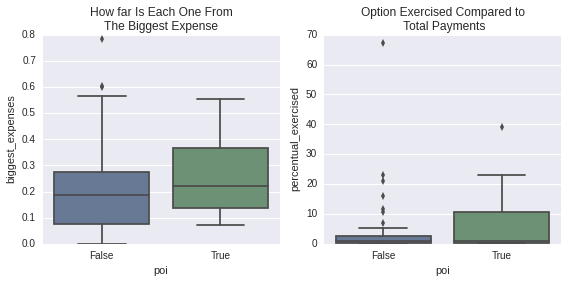

In [117]:
stats.excludeOutliers(l_outliers =  ["BELFER ROBERT","BHATNAGAR SANJAY", "TOTAL"])
stats.compareFeaturesCreated()

The distribution of both features is more dispersed when related to POIs. I guess that I can use them in the step of feature selection.
Lastly, as I intend to test the K-nn algorithm as one of the machine-learning candidates, I will use scaled and non-scaled features in my tests. As the features are in diffenrent units, but the most of them are related to money, 

#####Selecting the best ones

In [8]:
x = stats.describe()

In [14]:
SelectPercentile?

In [74]:
from sklearn.feature_selection import SelectPercentile, f_classif
### feature selection, because text is super high dimensional and 
### can be really computationally chewy as a result
selector = SelectPercentile(f_classif, percentile=40)
selector.fit(features, labels)
features_transformed = selector.transform(features)



/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `fprob` is deprecated!
fprob is deprecated in scipy 0.14, use stats.f.sf or special.fdtrc instead

  warnings.warn(depdoc, DeprecationWarning)


In [75]:
pd.DataFrame(features).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,4175000,2869717,-3081055,0,1729541,13868,2195,47,65,0,304805,152,126027,-126027,201955,1407,2902
1,0,178980,0,0,257817,3486,0,0,0,0,0,0,0,0,0,0,0
2,0,0,-5104,0,4046157,56301,29,39,0,0,0,864523,1757552,-560222,477,465,566
3,1200000,1295738,-1386055,0,6680544,11200,0,0,0,0,1586055,2660303,3942714,0,267102,0,0
4,400000,260455,-201641,0,0,129142,0,0,0,0,0,69,145796,-82782,239671,0,0


In [76]:
import pandas as pd

In [77]:
l_labels2 = [x for x, t in zip(features_list, [False] + list(selector.get_support())) if t]
pd.DataFrame(features_transformed, columns = l_labels2).head()

,bonus,deferred_income,exercised_stock_options,long_term_incentive,restricted_stock,salary,shared_receipt_with_poi
0,4175000,-3081055,1729541,304805,126027,201955,1407
1,0,0,257817,0,0,0,0
2,0,-5104,4046157,0,1757552,477,465
3,1200000,-1386055,6680544,1586055,3942714,267102,0
4,400000,-201641,0,0,145796,239671,0


In [24]:
import numpy as np

In [32]:
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
pd.Series(dict(zip(features_list[1:],scores)))

bonus                        0.857466
deferral_payments            0.035412
deferred_income              0.525508
director_fees                0.138048
exercised_stock_options      1.000000
expenses                     0.314408
from_messages                0.029685
from_poi_to_this_person      0.280534
from_this_person_to_poi      0.155928
loan_advances                0.362126
long_term_incentive          0.466340
other                        0.236019
restricted_stock             0.436342
restricted_stock_deferred    0.077987
salary                       0.769351
shared_receipt_with_poi      0.416611
to_messages                  0.119824
dtype: float64

In [47]:
-np.log10(selector.pvalues_)>=np.log10(50)

array([ True, False,  True, False,  True,  True, False, False, False,
        True,  True, False,  True, False,  True,  True, False], dtype=bool)

In [48]:
SelectPercentile?

based on [here](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html)...

In [39]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif

###############################################################################
# import some data to play with

# The iris dataset
iris = datasets.load_iris()

# Some noisy data not correlated
E = np.random.uniform(0, 0.1, size=(len(iris.data), 20))

# Add the noisy data to the informative features
X = np.hstack((iris.data, E))
y = iris.target

###############################################################################


X_indices = np.arange(X.shape[-1])

###############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 10% most significant features
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()


###############################################################################
# Compare to the weights of an SVM
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()



clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()



/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `fprob` is deprecated!
fprob is deprecated in scipy 0.14, use stats.f.sf or special.fdtrc instead

  warnings.warn(depdoc, DeprecationWarning)


In [58]:
import sklearn

In [63]:
import scipy

In [64]:
scipy.stats.f.sf

<bound method f_gen.sf of <scipy.stats._continuous_distns.f_gen object at 0x10aa8e2d0>>

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectPercentile, f_classif

clf = GaussianNB()

In [3]:
import sys
import pickle
sys.path.append("tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features
features_list = [u'poi', u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
 u'exercised_stock_options', u'expenses', u'from_messages', u'from_poi_to_this_person',
 u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive', u'other',
 u'restricted_stock', u'restricted_stock_deferred', u'salary', u'shared_receipt_with_poi',
 u'to_messages']
# features_list = [u'poi',u'total_payments', u'total_stock_value', u'from_messages', 
#                  u'from_poi_to_this_person',u'from_this_person_to_poi', u'shared_receipt_with_poi',
#                  u'to_messages']

### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

### Task 2: Remove outliers
key_to_remove = ['TOTAL',"BELFER ROBERT","BHATNAGAR SANJAY"]
for key in key_to_remove:
    data_dict.pop(key)

### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()    

In [100]:
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(features, labels)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `fprob` is deprecated!
fprob is deprecated in scipy 0.14, use stats.f.sf or special.fdtrc instead

  warnings.warn(depdoc, DeprecationWarning)


In [101]:
dict(zip(features_list[1:],scores))

{u'bonus': 0.8574663141912432,
 u'deferral_payments': 0.035411984089316902,
 u'deferred_income': 0.5255079654168372,
 u'director_fees': 0.13804768068962223,
 u'exercised_stock_options': 1.0,
 u'expenses': 0.31440783575470999,
 u'from_messages': 0.029685062649153496,
 u'from_poi_to_this_person': 0.2805342830010974,
 u'from_this_person_to_poi': 0.1559275026586654,
 u'loan_advances': 0.36212573386540942,
 u'long_term_incentive': 0.46633993937224083,
 u'other': 0.2360186678215476,
 u'restricted_stock': 0.43634156199167662,
 u'restricted_stock_deferred': 0.077987366538201291,
 u'salary': 0.76935061216283018,
 u'shared_receipt_with_poi': 0.41661149583594687,
 u'to_messages': 0.11982402879055559}

In [96]:
selector.pvalues_

array([  3.08462188e-03,   3.13664467e-06,   6.71463103e-01,
         2.63292855e-02,   1.31953828e-01,   4.50320014e-03,
         2.13891743e-01])

In [105]:
import numpy

In [106]:
numpy.argsort?

In [103]:
dict(zip(features_list[1:],selector.pvalues_<0.05))


{u'bonus': True,
 u'deferral_payments': False,
 u'deferred_income': True,
 u'director_fees': False,
 u'exercised_stock_options': True,
 u'expenses': True,
 u'from_messages': False,
 u'from_poi_to_this_person': True,
 u'from_this_person_to_poi': False,
 u'loan_advances': True,
 u'long_term_incentive': True,
 u'other': True,
 u'restricted_stock': True,
 u'restricted_stock_deferred': False,
 u'salary': True,
 u'shared_receipt_with_poi': True,
 u'to_messages': False}

In [74]:
df.columns

Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees', u'email_address', u'exercised_stock_options', u'expenses', u'from_messages', u'from_poi_to_this_person', u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive', u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred', u'salary', u'shared_receipt_with_poi', u'to_messages', u'total_payments', u'total_stock_value'], dtype='object')

###Pick and Tune an Algorithm

1. What algorithm did you end up using?  What other one(s) did you try? [relevant rubric item: “pick an algorithm”]
2. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm?  (Some algorithms don’t have parameters that you need to tune--if this is the case for the one you picked, identify and briefly explain how you would have done it if you used, say, a decision tree classifier). [relevant rubric item: “tune the algorithm”]

###Evaluation

1. What is validation, and what’s a classic mistake you can make if you do it wrong?  How did you validate your analysis?  [relevant rubric item: “validation strategy”]
2. Give at least 2 evaluation metrics, and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

###Reflection

####TODO:


<p>6/7/2015 - Keep the statistic summary as attribute and include the features selected and the bigger p_value ratio as new columns. Use it to present the results, sorted by p_values. From stats, show just count and the mean to justify the scaling</p>


<hr>
<em>
<p>6/30/2015 - Add a ratio of exercise stock options and total stock options. Justify by the movie. Maybe show a chart to answer why try it</p>
<p>7/3/2015 - As part of the assignment, you should attempt to engineer your own feature that doesn’t come ready-made in the dataset--explain what feature you tried to make, and the rationale behind it.  (You do not necessarily have to use it in the final analysis, only engineer and test it.) </p>
<p>6/27/2015 - Compare the summation of Payment and Stocks Features to see if all if correctly filled</p>
<p>6/26/2015 - probably is someone important....I could plot a heat map with all datapointsand from to_poi features, splitting it between POIs and non-POIS...in another section - will be not necessary</p>
</em>

<em>Custom CSS</em>

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read() )

In [86]:
#changing matplotlib defaults
import eda; reload(eda);
stats = eda.Eda()
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("darkgrid")